<h1><center>Machine Learning - Amazon Beauty Products</center></h1>

## Collaborative Filtering

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

%matplotlib inline
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

import gc

In [2]:
from sklearn.model_selection import train_test_split

from surprise import Reader, Dataset, accuracy

from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor
from surprise import KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import BaselineOnly, CoClustering
from surprise.model_selection import cross_validate, train_test_split

Read the cleaned file into dataframes.

In [3]:
meta = pd.read_csv('cleaned_metadata.csv',index_col=0)
reviews = pd.read_csv('cleaned_reviews.csv',index_col=0)

In [4]:
reviews[reviews['review'].isnull()]

,reviewerID,asin,overall,reviewTime,review,upvotes,downvotes,word_count,polarity
1360701,A1LF7KGH427GYC,B00552467Q,5,2014-07-08,NaN,0,0,2,0.0
1467181,AUII249W6FBZY,B00604MV0C,3,2013-01-11,NaN,0,0,2,0.0
1784718,A3BX2SSKN9SFRV,B00ADXZ9LY,1,2014-07-03,NaN,0,0,4,0.0


In [5]:
d = {5: "Excellent", 4:"Very Good", 3: "Good", 2:"Not Good", 1: "Bad"}
s = reviews.overall.map(d)
reviews['review'] = reviews['review'].combine_first(s)

In [6]:
d=None
s=None

In [7]:
reviews['review'] = reviews['review'].str.strip()

In [8]:
meta['description'] = meta['description'].fillna(meta['main_cat'])
meta['brand_title'] = meta['brand_title'].fillna(meta['main_cat'])
meta['price'] = meta['price'].fillna(0)

In [9]:
reviews.head(2)

,reviewerID,asin,overall,reviewTime,review,upvotes,downvotes,word_count,polarity
0,A39HTATAQ9V7YF,0205616461,5,2013-05-28,bioactive antiaging serum love moisturizer would recommend someone dry skin fine lines wrinkles using brand day night serum,0,0,34,0.283333
1,A3JM6GV9MNOF9X,0558925278,3,2012-12-14,product ok im use baby kabuki moment received product deadlinei tested baby kabuki quality material best packaging cute love itthe fibers smell soft,0,1,44,0.520000


In [10]:
usersperasin = reviews['asin'].value_counts()
asinsperuser = reviews['reviewerID'].value_counts()

In [11]:
sample = reviews[reviews['asin'].isin(usersperasin[usersperasin>5].index) & reviews['reviewerID'].isin(asinsperuser[asinsperuser>5].index)]

#sample = reviews[reviews['asin'].isin(usersperasin[usersperasin>10].index)]

In [12]:
sample.reset_index()

,index,reviewerID,asin,overall,reviewTime,review,upvotes,downvotes,word_count,polarity
0,36,A274NIJWOQWE30,1304351475,5,2013-11-24,thank best price ever love pallet buying natural eye faced year love colors one use best price ever seen listed pallet kind comes mirror awesome buy,2,3,67,0.671429
1,40,AN33X95J5460X,1304351475,4,2014-03-19,sparkly colors lovely yet would dare say sparkly pigmented enough least comparison urbandecay skin stone rather tan maybe palette wont show clearly skin tone brighter must perfect romantic palette,1,2,56,0.216667
2,45,A169NC0ZW6XKRD,1304482685,3,2014-02-05,boring kinda disappointingthe colors light although colors appear darknot thrilled,0,0,19,0.000000
3,47,A22ZFXQE8AWPEP,1304482685,1,2013-10-31,fake mac seriously doubt reviewers tell fake mac took store thought could exchange another item said mac doesnt make shocked amazon allows happen fake mac fake reviews,6,6,49,-0.505556
4,50,A22VW0P4VZHDE3,1304482685,5,2013-11-11,good money conscious bought multitude colors cheap price shadows may small nicely pigmented used primer great good money conscious makeup lover colorful college student,0,0,52,0.383333
...,...,...,...,...,...,...,...,...,...,...
318153,2023043,ASKZO80Z1RKTR,B00LLPT4HI,5,2014-07-13,wonderful soothing moisturizer 100 organic raw unrefined african shea butter grade arrived quickly little soft heat outsidei followed instructions placed 1 lb brick refrigerator 3060 minsafter hour took brick solid againfor regular use need cut little dime size brick apply anywhere wantit light nutty scentit moisturizing soothing sunburn products aloe vera gel otc comes ingredients fragrances lidocainepure organic shea butter natural vitamin e creamshea butter shown superb moisturizer exceptional healing properties skinit used healthy skin dry skin sunburns wrinkles use 46 weeks eczema insect bites itching relieved immediately dermatitis stretch mark prevention pregnancy shaving cream silky smooth skin skin allergies poison ivy poison oakjust much morethis best shea butter used yet shea butter comes oil reach seed african shea tree fda classifies tree nut allergic shea buttersample provided review honest opinion,1,1,228,0.278644
318154,2023046,A3UJRNI8UR4871,B00LLPT4HI,5,2014-07-22,real stuff 100 pure shea butter mistake 34shea butter34 products may contain little shea lots ingredients including chemicals stuff might wantthis real stuff34good news block last long time bad news even tho called 34butter cant eat itguys try shaving instead shaving cream,0,1,75,-0.046173
318155,2023057,A1IO9HRIA7ZJGU,B00LNOKBYW,5,2014-07-17,child friendly used curl niece8217s hair weeks ago wedding kid majorly hyper can8217t sit still minutes time worked fast enough didnt time get bored give little snack bribe machine didnt get hot great wiggly little kid kept telling like princess cute curls stayed nice even put dress stayed nice kept playing running around kids reception everyone including sister law asking got hair look wonderful got many compliments would recommend anyone kids also works really well decent price,0,0,161,0.273698
318156,2023060,A3EN0JCMEML724,B00LNOKBYW,5,2014-07-18,absolutely complaints product hair thanking ever since purchased curling iron harsh hair old curling iron old curling iron would potent stench burning hair hair product new curling iron smell potent actually dont really notice compared last curling iron reason adjust curling irons temperature meaning deal curling iron getting hot great news everyone,0,0,105,0.215530


In [13]:
sample['asin'].nunique()

48267

In [14]:
sample['reviewerID'].nunique()   ## 2023070 total

36065

In [15]:
sample.shape

(318158, 9)

In [16]:
sample.head()

,reviewerID,asin,overall,reviewTime,review,upvotes,downvotes,word_count,polarity
36,A274NIJWOQWE30,1304351475,5,2013-11-24,thank best price ever love pallet buying natural eye faced year love colors one use best price ever seen listed pallet kind comes mirror awesome buy,2,3,67,0.671429
40,AN33X95J5460X,1304351475,4,2014-03-19,sparkly colors lovely yet would dare say sparkly pigmented enough least comparison urbandecay skin stone rather tan maybe palette wont show clearly skin tone brighter must perfect romantic palette,1,2,56,0.216667
45,A169NC0ZW6XKRD,1304482685,3,2014-02-05,boring kinda disappointingthe colors light although colors appear darknot thrilled,0,0,19,0.000000
47,A22ZFXQE8AWPEP,1304482685,1,2013-10-31,fake mac seriously doubt reviewers tell fake mac took store thought could exchange another item said mac doesnt make shocked amazon allows happen fake mac fake reviews,6,6,49,-0.505556
50,A22VW0P4VZHDE3,1304482685,5,2013-11-11,good money conscious bought multitude colors cheap price shadows may small nicely pigmented used primer great good money conscious makeup lover colorful college student,0,0,52,0.383333


Surprise library has a set of built-in algorithms to perform collaborative filtering on explicit ratings.

In [17]:
reader=Reader(rating_scale=(0,5))

In [18]:
data = Dataset.load_from_df(sample[['reviewerID', 'asin', 'overall']], reader)

In [19]:
data

In [20]:
benchmark = []

We will use various algorithms to compute the RMSE

In [21]:
algorithm = SVD(n_factors=20, n_epochs = 30, biased=False)
results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
# Get results & append algorithm name
tmp = pd.DataFrame.from_dict(results).mean(axis=0)
tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
benchmark.append(tmp)

In [22]:
algorithm = SVD(n_factors=20, n_epochs = 30, biased=True)
results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
# Get results & append algorithm name
tmp = pd.DataFrame.from_dict(results).mean(axis=0)
tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
benchmark.append(tmp)

In [23]:
algorithm = SVDpp(n_factors=20, n_epochs = 30)
results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
# Get results & append algorithm name
tmp = pd.DataFrame.from_dict(results).mean(axis=0)
tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
benchmark.append(tmp)

In [24]:
algorithm = SlopeOne()  ### Gives MemoryError
results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
# Get results & append algorithm name
tmp = pd.DataFrame.from_dict(results).mean(axis=0)
tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
benchmark.append(tmp)

In [25]:
algorithm = NMF(n_factors=20, n_epochs = 30, biased=False)
results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
# Get results & append algorithm name
tmp = pd.DataFrame.from_dict(results).mean(axis=0)
tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
benchmark.append(tmp)

In [26]:
algorithm = NMF(n_factors=20, n_epochs = 30, biased=True)
results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
# Get results & append algorithm name
tmp = pd.DataFrame.from_dict(results).mean(axis=0)
tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
benchmark.append(tmp)

In [27]:
algorithm = KNNBaseline(n_factors=20, n_epochs = 30, biased=False)
results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
# Get results & append algorithm name
tmp = pd.DataFrame.from_dict(results).mean(axis=0)
tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
benchmark.append(tmp)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [28]:
algorithm = KNNBaseline(n_factors=20, n_epochs = 30, biased=True)
results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
# Get results & append algorithm name
tmp = pd.DataFrame.from_dict(results).mean(axis=0)
tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
benchmark.append(tmp)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [29]:
benchmark

[test_rmse    3.33    
 fit_time     7.64195 
 test_time    0.695053
 Algorithm    SVD     
 dtype: object, test_rmse    1.12403 
 fit_time     7.69381 
 test_time    0.820784
 Algorithm    SVD     
 dtype: object, test_rmse    1.13816
 fit_time     69.0879
 test_time    2.52819
 Algorithm    SVDpp  
 dtype: object, test_rmse    1.25428 
 fit_time     93.3048 
 test_time    9.83037 
 Algorithm    SlopeOne
 dtype: object, test_rmse    1.29403
 fit_time     89.1783
 test_time    5.57509
 Algorithm    NMF    
 dtype: object, test_rmse    1.15603
 fit_time     72.8777
 test_time    4.30724
 Algorithm    NMF    
 dtype: object, test_rmse    1.18329    
 fit_time     130.214    
 test_time    9.02692    
 Algorithm    KNNBaseline
 dtype: object, test_rmse    1.18292    
 fit_time     111.764    
 test_time    7.60629    
 Algorithm    KNNBaseline
 dtype: object]

In [30]:
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,1.124032,7.693815,0.820784
SVDpp,1.138161,69.087880,2.528187
NMF,1.156026,72.877697,4.307238
KNNBaseline,1.182920,111.764026,7.606291
KNNBaseline,1.183290,130.213831,9.026922
SlopeOne,1.254283,93.304755,9.830369
NMF,1.294032,89.178326,5.575087
SVD,3.329999,7.641953,0.695053


SVD with biased factor = True has the least RMSE so let's determine it's MAE also

In [31]:
algo = SVD(n_factors=20, n_epochs = 30, biased=True)
cross_validate(algo, data, measures=['RMSE','MAE'], cv=3, verbose=False)

{'test_rmse': array([1.12817591, 1.1215936 , 1.12293098]),
 'test_mae': array([0.85968867, 0.85843451, 0.85671202]),
 'fit_time': (11.261110305786133, 9.519094228744507, 9.36190128326416),
 'test_time': (0.9808320999145508, 1.065335750579834, 1.040271282196045)}

Let's split the dataset into train and test and check for accuracy

In [32]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = SVD(n_factors=20, n_epochs = 30, biased=True)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 1.1198


1.1198468624893345

In [33]:
accuracy.mae(predictions)

MAE:  0.8517


0.8516680940555704

The MAE is even lower for the SVD algorithm

In [34]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]


In [35]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
38635,A21T5C3KL41REL,B00GPWYF94,5.0,5.0,{'was_impossible': False},23,37,0.0
73204,ABW1LGKF1KIE2,B008Q0E714,5.0,5.0,{'was_impossible': False},11,63,0.0
42775,A3QX1PKDEDGIEW,B006GTKSHY,5.0,5.0,{'was_impossible': False},8,34,0.0
24549,A8C69Q1OOVFZW,B0063UN7PQ,5.0,5.0,{'was_impossible': False},7,2,0.0
53809,A390XPHE9J7DBO,B00JQP1SP6,5.0,5.0,{'was_impossible': False},46,33,0.0
53821,AC3HTUCNI2I04,B0046MZNH8,5.0,5.0,{'was_impossible': False},8,8,0.0
53826,A2KJWZ7I24GMQC,B00JL2TURM,5.0,5.0,{'was_impossible': False},15,53,0.0
77773,A1SSXXAPHDYWNP,B008Q0E714,5.0,5.0,{'was_impossible': False},6,63,0.0
53836,AD526SECC3I9D,B001CPM03C,5.0,5.0,{'was_impossible': False},7,27,0.0
53846,A2F9MEJHHUU9M2,B00FW6ELDY,5.0,5.0,{'was_impossible': False},9,11,0.0


In [36]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
41606,A2JQHSICQ2LVF4,B004R7R8G6,1.0,5.0,{'was_impossible': False},14,7,4.0
24494,A1G3RLG5R6YJH8,B004VB48LQ,1.0,5.0,{'was_impossible': False},13,4,4.0
16988,ALJ1S9LOYB08X,B000ZMBSPE,1.0,5.0,{'was_impossible': False},9,322,4.0
50113,A6KTMD1302DH3,B005GQ6F4I,1.0,5.0,{'was_impossible': False},12,17,4.0
67189,A31QEIE49EC2R8,B003E23I96,1.0,5.0,{'was_impossible': False},9,3,4.0
57403,AEMV9IMH665B9,B003HG4GQI,1.0,5.0,{'was_impossible': False},17,37,4.0
5687,A1F5KKZRXJWKIT,B00429BV3K,1.0,5.0,{'was_impossible': False},14,27,4.0
17123,A1F5KKZRXJWKIT,B00AXL7YH8,1.0,5.0,{'was_impossible': False},14,5,4.0
36072,A3A7Y3TSPPZU9T,B0006Q3NTS,1.0,5.0,{'was_impossible': False},32,43,4.0
8671,A9X08IY6Y9FL3,B003S516XO,1.0,5.0,{'was_impossible': False},6,103,4.0


Let's take a look at one of the products that received worst predictions

<IPython.core.display.Javascript object>


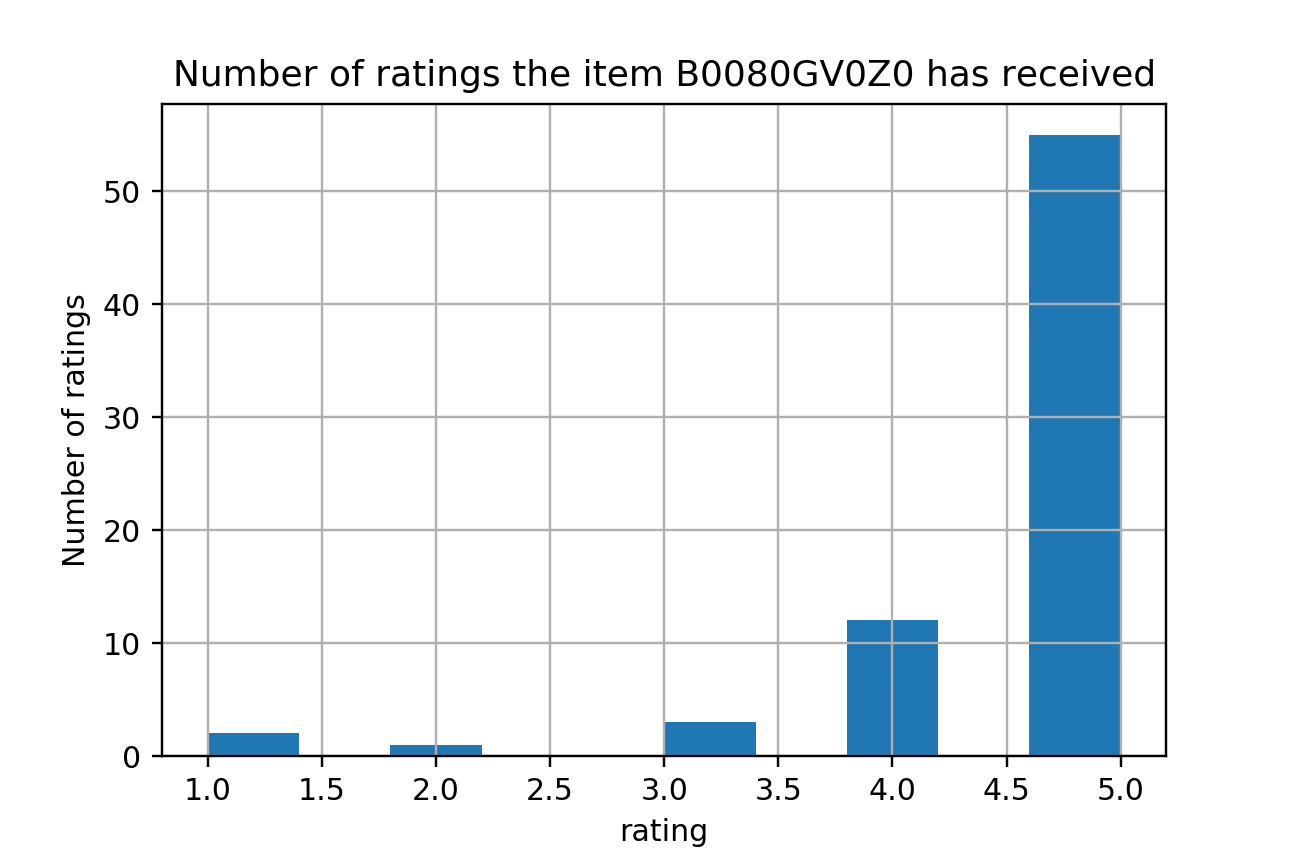

In [37]:
import matplotlib.pyplot as plt
%matplotlib notebook
sample.loc[sample['asin'] == 'B0080GV0Z0']['overall'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings the item B0080GV0Z0 has received')
plt.show();

Cross validation for Item-item collaborative filtering

In [38]:
sim_options1 = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5,
               'user_based': [False]
               }
algo = KNNBaseline(sim_options=sim_options1)
cross_validate(algo, data, measures=['RMSE','MAE'], cv=3, verbose=False)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


{'test_rmse': array([1.18406095, 1.18159015, 1.17942461]),
 'test_mae': array([0.89576793, 0.89338561, 0.8928422 ]),
 'fit_time': (106.42981910705566, 136.84375143051147, 117.78566384315491),
 'test_time': (7.923354864120483, 8.764350652694702, 7.8265461921691895)}

In [39]:
algo = KNNBaseline(sim_options=sim_options1)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)
accuracy.mae(predictions)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.1865
MAE:  0.8927


0.8926613822041234

Cross validation for User-User collaborative filtering

In [40]:
sim_options2 = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5,
               'user_based': [True]
               }
algo = KNNBaseline(sim_options=sim_options2)
cross_validate(algo, data, measures=['RMSE','MAE'], cv=3, verbose=False)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


{'test_rmse': array([1.18379978, 1.18429416, 1.18196273]),
 'test_mae': array([0.89632631, 0.89613961, 0.89356182]),
 'fit_time': (85.51116824150085, 108.66783308982849, 107.83713150024414),
 'test_time': (7.296968698501587, 7.1727375984191895, 7.937410831451416)}

In [41]:
#trainset, testset = train_test_split(data, test_size=0.25)
algo = KNNBaseline(sim_options=sim_options2)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)
accuracy.mae(predictions)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.1865
MAE:  0.8927


0.8926613822041234

In [42]:
#reviews[reviews['asin'] == '0205616461']

In [43]:
# Training recommendation model steps: 1
def getSimModel(sim_options):
    algo = KNNBaseline(sim_options=sim_options)
    algo.fit(trainset)
    return algo

In [44]:
# Recommendation steps for related products based on the previous training model
def showSimilarItems(algo, item):
    # Convert raw_id of an item to the internal ID of the model
    item_inner_id = algo.trainset.to_inner_iid(item)
    # Get Top-10 Recommended Items from Model
    item_neighbors = algo.get_neighbors(item_inner_id, 10)

    # The internal id of the model is converted to the actual item id
    neighbors_items = [algo.trainset.to_raw_iid(inner_id) for inner_id in item_neighbors]

    print('The 10 nearest neighbors of this item are:')
    for nitems in neighbors_items:
        print(nitems)


In [45]:
# Training Recommendation Model Item-based
algo = getSimModel(sim_options1)

# Display related products
showSimilarItems(algo, 'B004HAMIJA')

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
The 10 nearest neighbors of this item are:
B005OZTE7Q
B001U0OQN6
B000C1UFHU
B00C41DH8U
B001CZE8HI
B000N2MPLW
B004510MT4
B0062VQRU8
B005KL8BG4
B008HBMRIC


In [46]:
# Training Recommendation Model User-based
algo = getSimModel(sim_options2)

# Display related products
showSimilarItems(algo, 'B004HAMIJA')

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
The 10 nearest neighbors of this item are:
B005OZTE7Q
B001U0OQN6
B000C1UFHU
B00C41DH8U
B001CZE8HI
B000N2MPLW
B004510MT4
B0062VQRU8
B005KL8BG4
B008HBMRIC


In [47]:
top10knn = pd.DataFrame(['B000N94R66', 'B000VPPUEA', 'B0018X1WLY', 'B001ECQ4HQ', 'B002BWPXGQ', 'B000RG2YFQ', 'B004C1VIPY','B004Q8GYES','B0074MTNDM','B004Y9GVZG'], index=np.arange(10), columns=['asin'])
summary = pd.merge(top10knn, meta, on='asin')
summary[['asin','brand_title','main_cat']].head(10)

,asin,brand_title,main_cat
0,B000N94R66,Make Up For Ever MAKE UP FOR EVER Mat Velvet + Mat,Makeup
1,B000VPPUEA,"Bio Bio-Oil, 2-Ounce Bottle",Skin Care
2,B0018X1WLY,DL Professional DL Professional Acrylics Nail Gel,Tools & Accessories
3,B001ECQ4HQ,"Dove Dove White Beauty Bar, 14 Count (Pack of 2)",Bath & Body
4,B002BWPXGQ,"RoC Multi-Correxion Skin Renewing Serum, 1 Ounce",Skin Care
5,B000RG2YFQ,Ardell Ardell LashGrip Adhesive for Strip Lashes -,Tools & Accessories
6,B004C1VIPY,Biotique Botanicals Biotique Botanicals Bhringraj,Hair Care
7,B004Q8GYES,Neutrogena Neutrogena Wave Sonic Power Cleanser wi,Skin Care
8,B0074MTNDM,Thermafuse ThermaFuse HeatSmart Serum Condition 10,Hair Care
9,B004Y9GVZG,Maybelline Maybelline New York Instant Age Rewind,Skin Care


In [48]:
algo=None
df=None
tmp=None
predictions=None
benchmark=None

### Correlation based recommendations

Pearson's r correlation is used to recommend an item that is most similar to an item chosen by the user.

Item-based similarity: How correlated are two items based on user ratings? Recommend an item based on how well it correlates with other items with respect to user ratings.

r=1: Strong positive linear correlation
r=0: No correlation
r=-1: Strong negative linear correlation

In [49]:
data = meta.merge(reviews, on='asin')
#data.head(2)

In [50]:
data['asin'].nunique()

249274

In [51]:
data.shape

(2023070, 17)

In [52]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2023070 entries, 0 to 2023069
Data columns (total 17 columns):
asin                    2023070 non-null object
description             2023070 non-null object
price                   2023070 non-null float64
brand_title             2023070 non-null object
health_personal_care    2023070 non-null float64
beauty                  2023070 non-null float64
main_cat                2023070 non-null object
sub_cat                 2023070 non-null object
related_count           2023070 non-null float64
reviewerID              2023070 non-null object
overall                 2023070 non-null int64
reviewTime              2023070 non-null object
review                  2023070 non-null object
upvotes                 2023070 non-null int64
downvotes               2023070 non-null int64
word_count              2023070 non-null int64
polarity                2023070 non-null float64
dtypes: float64(5), int64(4), object(8)
memory usage: 277.8+ MB


In [53]:
rating = pd.DataFrame(data.groupby('asin')['overall'].mean())
rating.head()

,overall
asin,
0205616461,5.0
0558925278,4.0
0733001998,4.0
0737104473,1.0
0762451459,5.0


In [54]:
rating['rating_count'] = pd.DataFrame(data.groupby('asin')['overall'].count())
rating.head()

,overall,rating_count
asin,,
0205616461,5.0,1
0558925278,4.0,2
0733001998,4.0,1
0737104473,1.0,1
0762451459,5.0,1


In [55]:
rating.describe()

,overall,rating_count
count,249274.000000,249274.000000
mean,4.149251,8.115848
std,1.047265,36.064113
min,1.000000,1.000000
25%,3.750000,1.000000
50%,4.500000,2.000000
75%,5.000000,5.000000
max,5.000000,7533.000000


In [56]:
rating.sort_values('rating_count', ascending=False).head()

,overall,rating_count
asin,,
B001MA0QY2,4.321386,7533
B0009V1YR8,3.568839,2869
B0043OYFKU,4.310456,2477
B0000YUXI0,4.405040,2143
B003V265QW,4.365421,2088


In [57]:
#data[data['asin']=='0558925278']

In [58]:
#data.loc[data['asin'] == 'B0055MYJ0U', 'reviewerID'].unique()

Sparsity of item-user matrix. Lot of null values because not everyone reviews every item. Few people review few items that they bought and either liked or disliked.

Check correlation using pearsonr method. If correlation with an item is high but that item doesn't have many ratings, then it isn't very popular and relation will not be significant. So keep rating_count column in mind. Create filter where no of ratings more than a threshold value and Sort values in pearson correlation descending.

In [59]:
usersperasin = data['asin'].value_counts()
asinsperuser = data['reviewerID'].value_counts()

data_s = data[data['asin'].isin(usersperasin[usersperasin>5].index) & data['reviewerID'].isin(asinsperuser[asinsperuser>5].index)]

In [60]:
data=None
gc.collect()

120

In [61]:
data_s.shape

(318158, 17)

In [62]:
data_s.loc[data_s['asin'] == 'B001MA0QY2', 'brand_title'].unique()  

array(['HSI PROFESSIONAL HSI PROFESSIONAL 1 CERAMIC TOURMA'], dtype=object)

In [63]:
asin_crosstab = pd.pivot_table(data=data_s, values='overall', index='reviewerID', columns='asin')

In [64]:
#asin_crosstab.head(2)

In [65]:
hsiprof_ratings = asin_crosstab['B001MA0QY2']
hsiprof_ratings[hsiprof_ratings>=0]

reviewerID
A03236882LUP4ARMDDMXU    5.0
A10S8JTRCL7BR            5.0
A10SQR3U7RMY8C           5.0
A10XKNOCVRDXHG           4.0
A10Z57SSF7FEAN           5.0
                        ... 
AWBGHDHH7E51F            5.0
AWVLT2L5AP873            5.0
AYHX5DR7FM16U            1.0
AYYKQ776T8DKG            1.0
AZ405VGOJ2SDV            5.0
Name: B001MA0QY2, Length: 300, dtype: float64

#### Evaluating Similarity based on Correlation

In [66]:
sim_hsiprof = asin_crosstab.corrwith(hsiprof_ratings)
corr_hsiprof = pd.DataFrame(sim_hsiprof, columns=['PearsonR'])

In [67]:
corr_hsiprof.dropna(inplace=True)
corr_hsiprof.head()

,PearsonR
asin,
B000052YM7,0.904534
B0000XMQTA,1.000000
B0000Y3GF2,-1.000000
B0001Y74VS,-1.000000
B00021DJ32,1.000000


In [68]:
hsiprof_corr_summary = corr_hsiprof.join(rating['rating_count'])

In [69]:
hsiprof_corr_summary[hsiprof_corr_summary['rating_count']>=10].sort_values('PearsonR', ascending=False).head(10)

,PearsonR,rating_count
asin,,
B004TSFE28,1.0,414
B000IOFQWK,1.0,479
B001ABLKK2,1.0,377
B002LB75AO,1.0,1079
B001824J5G,1.0,89
B002WTC37A,1.0,773
B0000XMQTA,1.0,63
B00121UVU0,1.0,1838
B0036I8BPE,1.0,169


Higher the PearsonR value, more similar the items are. 

In [70]:
asin_corr_hsiprof = pd.DataFrame(['B004TSFE28','B000IOFQWK','B001ABLKK2','B002LB75AO','B001824J5G','B002WTC37A','B0000XMQTA','B00121UVU0','B0036I8BPE','B000W9WZ34'], index=np.arange(10),columns=['asin'])
summary=pd.merge(asin_corr_hsiprof, meta, on='asin')
summary[['asin','brand_title','main_cat']].head(10)

,asin,brand_title,main_cat
0,B004TSFE28,Real Techniques real Techniques Starter Set,Tools & Accessories
1,B000IOFQWK,Sun Laboratories Sun Laboratories Tan Overnight Se,Skin Care
2,B001ABLKK2,Toyo Life Service Cure Natural Aqua Gel 250ml - Be,Skin Care
3,B002LB75AO,Clarisonic Mia Sonic Skin Cleansing System - Blue,Tools & Accessories
4,B001824J5G,GOT 2B got2b Smooth Operator Smoothing Lustre Loti,Hair Care
5,B002WTC37A,"Macadamia Oil Macadamia Oil Deep Repair Mask, 8.5",Hair Care
6,B0000XMQTA,Irene Gari Irene Gari Cover Your Grey for Women To,Hair Care
7,B00121UVU0,O&#39;Keeffe&#39;s Company O'Keeffe's Working Hand,Skin Care
8,B0036I8BPE,Kanechom Brazilian Hair Treatment Goat's Milk - (L,Hair Care
9,B000W9WZ34,Maybelline Maybelline New York Define-A-Lash Lengt,Makeup


In [71]:
#data_s[data_s['asin'] == '9746427962']

In [72]:
#data_s.head(2)
#data_s[(data_s.reviewerID == 'A18M9192WX98HP') & (data_s.overall == 5)]

In [73]:
from scipy.spatial.distance import hamming

def distance(user1,user2):
        try:
            user1Ratings = asin_crosstab.transpose()[str(user1)]
            user2Ratings = asin_crosstab.transpose()[str(user2)]
            distance = hamming(user1Ratings,user2Ratings)
        except: 
            distance = np.NaN
        return distance 
#%%
def nearestNeighbors(user,K=10):
    allUsers = pd.DataFrame(asin_crosstab.index)
    allUsers = allUsers[allUsers.reviewerID!=user]
    allUsers["distance"] = allUsers["reviewerID"].apply(lambda x: distance(user,x))
    KnearestUsers = allUsers.sort_values(["distance"],ascending=True)["reviewerID"][:K]
    return KnearestUsers

In [74]:
meta_s = meta.copy()

In [75]:
def asinmeta(asin):
    brand = meta_s.at[asin,"brand_title"]
    mcat = meta_s.at[asin,"main_cat"]
    return brand, mcat

def faveasin(user,N):
    userRatings = data_s[data_s["reviewerID"]==user]
    sortedRatings = pd.DataFrame.sort_values(userRatings,['overall'],ascending=[0])[:N] 
    #sortedRatings["brand_title"] = sortedRatings["asin"].apply(asinmeta)
    return sortedRatings['brand_title']

def topN(user,N=3):
    KnearestUsers = nearestNeighbors(user)
    NNRatings = asin_crosstab[asin_crosstab.index.isin(KnearestUsers)]
    avgRating = NNRatings.apply(np.nanmean).dropna()
    asinrated = asin_crosstab.transpose()[user].dropna().index
    avgRating = avgRating[~avgRating.index.isin(asinrated)]
    topNISBNs = avgRating.sort_values(ascending=False).index[:N]
    return pd.Series(topNISBNs).apply(asinmeta)

In [76]:
meta_s.set_index('asin', inplace=True)

In [77]:
meta_s.index

Index(['0205616461', '0558925278', '0733001998', '0737104473', '0762451459',
       '1304139212', '130414674X', '130414089X', '1304196062', '1304146537',
       ...
       'B00LMOT7X4', 'B00LMXHR1Y', 'B00LMWUR9O', 'B00LNOKBYW', 'B00LORWRJA',
       'B00LP2YB8E', 'B00LOS7MEE', 'B00LPVG6V0', 'B00LTDUHJQ', 'B00LU0LTOU'],
      dtype='object', name='asin', length=259204)

In [78]:
asinmeta('9746427962')

('Nivea Nivea Visage Q10 Plus Anti Wrinkle Night Car', 'Skin Care')

In [79]:
faveasin('A18M9192WX98HP', 5)

488        Nivea Nivea Visage Q10 Plus Anti Wrinkle Night Car
385262     Crabtree &amp; Evelyn Evelyn Rose - Body Lotion   
1905924    Mountain Fresh Soaps ~ FOUR PACK ~ Natural &amp; O
1840224    Acure Organics Acure Organics - Marula Oil Treatme
1776926    Rasta Locks &amp; Twist Jamaican Mango &amp; Lime 
Name: brand_title, dtype: object

In [80]:
topN('A18M9192WX98HP', 5)

0    (Jumbl&trade; Portable Lighted 5x Cosmetic Mirror w, Tools & Accessories)
1    (Real Purity Real Purity Foundation - Honey Beige, Makeup)               
2    (Anti-aging Cream - Perfective Ceuticals Divine Age, Skin Care)          
3    (Minera Minera Dead Sea Salt 20 Lbs Fine Grain, Bath & Body)             
4    (Dr. Denese Dr. Denese Advanced Firming Facial Pads, Skin Care)          
Name: asin, dtype: object

### Model based collaborative filtering systems

A user-item matrix is mostly empty (also called sparse). Reducing the dimensions can improve the performance of the algorithm in terms of both space and time. Methods such as matrix factorization or autoencoders can be used to accomplish this.

Matrix factorization is an algorithm which decomposes a sparse utility matrix into two or more matrices, such that their dot product results back into the original matrix. In a recommendation system, we start with an utility matrix between users and items and matrix factorization will decompose this matrix into user and item feature matrices, also known as embeddings. 

Typically user/item embeddings capture latent features about attributes of users and item respectively. Latent features represent users and items in an arbitrary space which represents how a user rate an item.

In [81]:
from sklearn.decomposition import TruncatedSVD

In [82]:
data_s.groupby('asin')['overall'].count().sort_values(ascending=False)

asin
B0043OYFKU    433
B000ZMBSPE    428
B004OHQR1Q    425
B000142FVW    392
B0069FDR96    368
             ... 
B000VEN44E    1  
B000VEN444    1  
B00869PO4O    1  
B0086AWC7U    1  
B003F62G3U    1  
Name: overall, Length: 48267, dtype: int64

In [83]:
filter = data_s['asin']=='B0043OYFKU'
data_s[filter]['brand_title'].unique()

array(['Olay Olay Pro-X Advanced Cleansing System 0.68 Fl '], dtype=object)

#### Building a utility matrix

In [84]:
data_s.groupby(['reviewerID','asin'])['overall'].sum()

reviewerID             asin      
A00414041RD0BXM6WK0GX  B007IY97U0    3
                       B00870XLDS    2
                       B008MIRO88    1
                       B00BQYYMN0    3
                       B00GRTQBTM    5
                                    ..
AZZZLM1E5JJ8C          B000QE5GU4    5
                       B004CQ710U    1
                       B005RFI1YK    5
                       B005XP4YNQ    3
                       B006ZUEMSA    1
Name: overall, Length: 318158, dtype: int64

In [85]:
data_s.shape

(318158, 17)

In [86]:
sample_df = data_s[:50000].copy()
rating_crosstab = pd.pivot_table(sample_df, values='overall', index='reviewerID', columns='asin', fill_value=0)

In [87]:
#rating_crosstab.head(2)

#### Transposing the matrix

In [88]:
rating_crosstab.shape

(22900, 7736)

In [89]:
X = rating_crosstab.values.T
X.shape

(7736, 22900)

#### Decomposing the matrix

In [90]:
SVD = TruncatedSVD(n_components=12, random_state=17)

resultant_matrix = SVD.fit_transform(X)

resultant_matrix.shape

(7736, 12)

In [91]:
resultant_matrix

array([[ 9.78291261e-03,  6.31594114e-03,  1.26659224e-02, ...,
        -2.20280408e-02,  1.94143464e-02, -1.78322695e-02],
       [ 1.34552577e-04,  4.48728952e-04,  5.70669234e-04, ...,
         1.68704640e-04, -1.48487766e-04, -4.20989285e-04],
       [-1.18893564e-14, -1.12693263e-11,  9.57989995e-12, ...,
        -2.09770305e-10, -9.19617760e-10,  1.32548093e-09],
       ...,
       [ 3.25260569e-04,  1.74912312e-03,  1.75995018e-03, ...,
        -2.83550896e-06,  6.15325622e-03,  1.32149447e-02],
       [ 2.27009431e-02,  1.24355225e-01,  1.04591059e-01, ...,
        -2.29018564e-01,  4.57525640e-01,  7.89258021e-02],
       [ 7.32311200e-04,  4.25128113e-04,  4.72239919e-04, ...,
        -1.24935711e-03, -7.19606226e-05,  2.60048649e-03]])

#### Generating a Correlation matrix

To make the best recommendation, recommend the item that correlates the most with the user's item of interest, based on the generalized user tastes. Goal is to recommend the item that has highest correlation with the item of user's interest.

In [92]:
corr_matrix = np.corrcoef(resultant_matrix)
corr_matrix.shape

(7736, 7736)

In [93]:
item_names = rating_crosstab.columns
item_list = list(item_names)

In [94]:
#item_list

In [95]:
my_item = item_list.index('9746427962')

In [96]:
print(my_item)

18


In [97]:
corr_my_item = corr_matrix[my_item]
corr_my_item.shape

(7736,)

#### Recommending a highly correlated item

In [98]:
list(item_names[(corr_my_item < 1.0) & (corr_my_item > 0.9)])

['9790778309',
 'B00028LV4Y',
 'B00099E8ZA',
 'B0009RFAOK',
 'B000BTAVIQ',
 'B000BTQKYA',
 'B000EGIF9S',
 'B000EM7962',
 'B000F371GS',
 'B000FQBBZ2',
 'B000GCR104',
 'B000H30FGY',
 'B000HS6O64',
 'B000KUAKTG',
 'B000OO7L1S']

In [99]:
asinmeta('9746427962')

('Nivea Nivea Visage Q10 Plus Anti Wrinkle Night Car', 'Skin Care')

In [100]:
for l_item in list(item_names[(corr_my_item < 1.0) & (corr_my_item > 0.9)]):
    print(asinmeta(l_item))

('HUGO BOSS Hugo Boss Cologne for Men, Green, 5.0 Fl', 'Fragrance')
('Aubrey Organics Natural Missst Herbal Hairspray Mi', 'Hair Care')
('Neutrogena Neutrogena Shampoo, Anti-Residue Formul', 'Hair Care')
('Clean &amp; Clear Clean &amp; Clear Deep Cleaning ', 'Skin Care')
('Folicure Folicure Shampoo, 12 Ounce', 'Hair Care')
('Folicure Folicure Moisturizing Conditioner, 12 Oun', 'Hair Care')
('Organic Root Stimulator Organic Root Stimulator Fe', 'Skin Care')
('Matrix Matrix Vavoom Freezing Spray , 12 oz (340 g', 'Hair Care')
('Neutrogena Relaxing Overnight Body Cream, Lavender', 'Skin Care')
('Kiss My Face Kiss My Face - Olive &amp; Green Tea ', 'Bath & Body')
('John Frieda John Frieda Brilliant Brunette Shine R', 'Hair Care')
('AMERICAN CREW American Crew D:fi D:struct Pliable ', 'Hair Care')
("Swissco Oakwood Men's Military Boar Bristle Club B", 'Hair Care')
('Nivea Nivea Visage Q10 Plus Anti-Wrinkle Day Cream', 'Skin Care')
('Naturtint Hair Color-7C/Terracotta Blonde Naturtin', 'Hair 

#### Pros:

1. Collaborative filtering method is context independent and easy to implement.

2. It can be more accurate than content-based filtering.

#### Cons:

1. The cost of computing nearest K-neighbors increases dramatically with the number of users. 

2. Cold start problem is unavoidable for new users with little or no interaction history.